In [1]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Conv1D,MaxPooling1D,AveragePooling1D
from keras.layers import Dense, Dropout, Activation, Flatten, Embedding, LSTM
from keras import optimizers
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob

Using TensorFlow backend.


In [2]:
# Read csv files and append them to list
path = 'D:/Datasets/IOTSensor/ActivityRecognition/'
csv_files = glob.glob(path + "/*.csv")
big_frame = pd.DataFrame()
csv_list = []
for file in csv_files:
    df = pd.read_csv(file)
    csv_list.append(df)

In [3]:
# Pass the dataset to dataframe
df = pd.concat(csv_list, axis=0)
print('Number of columns in the dataset: %i' % (df.shape[1]))
print('Number of rows in the dataset: %i\n' % (df.shape[0]))

Number of columns in the dataset: 5
Number of rows in the dataset: 1926897



In [4]:
# Remove null values and data labeled 0
df=df.dropna()
df = df[df.Label != 0]
#Dataset shape
print(df.shape)
#print list of label values
print(df['Label'].unique().tolist())

(1923176, 5)
[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]


In [5]:
df.head()

,Unnamed: 0,x,y,z,Label
0,0.0,1502.0,2215.0,2153.0,1.0
1,1.0,1667.0,2072.0,2047.0,1.0
2,2.0,1611.0,1957.0,1906.0,1.0
3,3.0,1601.0,1939.0,1831.0,1.0
4,4.0,1643.0,1965.0,1879.0,1.0


In [6]:
#Classify the data into composite and non-composite
#Create another column bLabel
df['bLabel'] = df['Label'].apply(lambda x: 1 if x == 2 else 1 if x == 5 else 1 if x == 6 else 1 if x == 7 else 0)

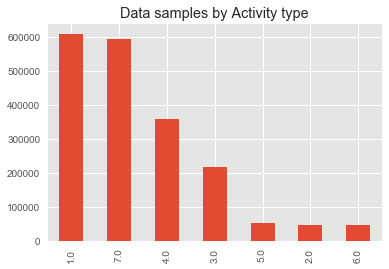

In [7]:
# Plot the distribution of data samples across the labels
sns.set() 
plt.style.use('ggplot')
labels =[1,2,3,4,5,6,7]
Labels = ['Working at Computer','Standing Up Walking and Going updownstairs',
          'Standing', 'Walking','Going UpDown Stairs','Walking and Talking with someone','Talking while Standing']
df['Label'].value_counts().plot(kind='bar', title='Data samples by Activity type')
plt.show()

In [8]:
#Normalize the data
df['x'] = df['x'] / df['x'].max()
df['y'] = df['y'] / df['y'].max()
df['z'] = df['z'] / df['z'].max()

# Round numbers to 3 decimals
df  = df.round({'x': 3, 'y':3 , 'z': 3})

In [9]:
# Split the dataset
from sklearn.model_selection import train_test_split
train, test = train_test_split(df,test_size=0.2, random_state=42)
X_train = train[['x','y','z']]
X_test  = test[['x','y','z']]
#Y_train = train['Label']
#Y_test  = test['Label']
Y_train = train['bLabel']
Y_test  = test['bLabel']

In [10]:
#Reshape the training and test data
#x = np.array(X_train).reshape((X_train.shape[0],3,1))
x_train = np.array(X_train).reshape((X_train.shape[0],1,3))
x_test  = np.array(X_test).reshape((X_test.shape[0],1,3))

In [11]:
#TRANSFORM labels into matrix
#encoder = LabelEncoder()
#encoder.fit(Y_train)
#Encoded_train = encoder.transform(Y_train)

#y_train = np_utils.to_categorical(Y_train)
#y_test = np_utils.to_categorical(Y_test)

y_train = Y_train
y_test =  Y_test
y_train.shape

(1538540,)

In [12]:
#Remove the 1st column of matrix, it's redundant, coming from to_categorical
#y_train= y_train[0:,1:]
#y_test = y_test[0:,1:]
#y_train.shape

In [13]:
random_seed = 611
np.random.seed(random_seed)
numOfRows = X_train.shape[0]
numOfColumns = X_train.shape[1]
inputShape=(1,3)
filterNo = 128
kernelSize = 1
poolingSize = 1
Epochs = 10
batchSize = 200
#noClasses = y_train.shape[1]
noClasses = 1
dropOutRatio = 0.2

model = Sequential()
model.add(Conv1D(filters=filterNo, kernel_size=kernelSize, activation='relu', input_shape=inputShape))
model.add(Conv1D(filters=filterNo, kernel_size=kernelSize, activation='relu'))
model.add(MaxPooling1D(pool_size=poolingSize))
model.add(Conv1D(filters=filterNo, kernel_size=kernelSize, activation='relu'))
model.add(Conv1D(filters=filterNo, kernel_size=kernelSize, activation='relu'))
model.add(MaxPooling1D(pool_size=poolingSize))
#model.add(AveragePooling1D(pool_size=poolingSize))

model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
#model.add(Dense(noClasses, activation='softmax'))
model.add(Dense(noClasses, activation='sigmoid'))

#Compile the model and print its summary
adam = optimizers.Adam(lr = 0.001, decay=1e-6)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 1, 128)            512       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1, 128)            16512     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1, 128)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1, 128)            16512     
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 1, 128)            16512     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 1, 128)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 128)            0         
__________

In [14]:
from keras.models import model_from_json
model_json = model.to_json()
with open("model1.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model1.h5")
print("model1 saved")

model1 saved


In [15]:
# Fit model on training data
model_train = model.fit(x_train,y_train, epochs=Epochs, batch_size=batchSize, verbose=2)

Epoch 1/10
 - 255s - loss: 0.5747 - acc: 0.6938
Epoch 2/10
 - 255s - loss: 0.4799 - acc: 0.7755
Epoch 3/10
 - 298s - loss: 0.4583 - acc: 0.7900
Epoch 4/10
 - 268s - loss: 0.4483 - acc: 0.7968
Epoch 5/10
 - 294s - loss: 0.4436 - acc: 0.7994
Epoch 6/10
 - 285s - loss: 0.4383 - acc: 0.8028
Epoch 7/10
 - 297s - loss: 0.4324 - acc: 0.8068
Epoch 8/10
 - 293s - loss: 0.4309 - acc: 0.8076
Epoch 9/10
 - 298s - loss: 0.4274 - acc: 0.8093
Epoch 10/10
 - 297s - loss: 0.4268 - acc: 0.8097


In [16]:
#Evaluate model
score = model.evaluate(x_test, y_test, batch_size=batchSize, verbose=1)
print("\n Test Accuracy: %0.2f" % score[1])
print("\n Test Loss: %0.2f" % score[0])

384636/384636 [==============================] - 23s 60us/step

 Test Accuracy: 0.81

 Test Loss: 0.42


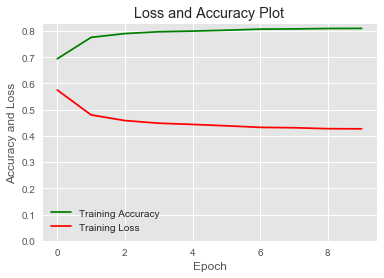

In [17]:
# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(model_train.history['acc'], "g-", label="Training Accuracy")
#plt.plot(model_train.history['val_acc'], "g--", label=" Validation Accuracy")
plt.plot(model_train.history['loss'], "r-", label="Training Loss")
#plt.plot(model_train.history['val_loss'], "r--", label="Validation Loss")
plt.title('Loss and Accuracy Plot')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Epoch')
plt.ylim(0)
plt.legend()
plt.show()

In [18]:
#CHANGE TRAINING TO REFLECT MOVEMENT

In [19]:
predictions = model.predict(x_test)

In [65]:
from sklearn.metrics import classification_report, confusion_matrix
pred_list = []; actual_list = [];
for i in predictions:
     pred_list.append(np.round(i)) 
for i in y_test:
     actual_list.append(i)
        
matrix = confusion_matrix(actual_list, pred_list)

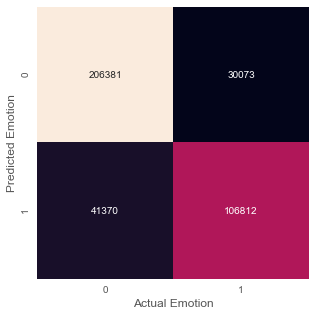

In [73]:
import seaborn as sns
plt.figure(figsize=(5, 5))
sns.heatmap(matrix, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('Actual Emotion')
plt.ylabel('Predicted Emotion');
plt.show()